This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

In [1]:
maximum_comoving_distance = 1.389556413208e+04;

In [2]:
max_co_dist_for_survey = 1.389556413208e+04/3

4631.854710693334

In [3]:
corr_max_redshift_for_survey = 1.663683173266e+00

1.663683173266

# Effective 𝑓_NL

This ipynb provides the code necessary to compute the effective factor of Non-Linear effects $\mathit{f}_{\rm NL}$.

All the output files will be placed in the following directory:

In [4]:
DIR = "Effective_fNL_z115_files/";

## Basic Framework

In [5]:
function readxy(input::String; comments::Bool = true)
    table = readdlm(input, comments=comments);
    xs = convert(Vector{Float64}, table[:,1]);
    ys = convert(Vector{Float64}, table[:,2]);
    return (xs, ys)
end;

function readxall(input::String; comments::Bool = true)
    table = readdlm(input, comments=comments);
    xs = convert(Vector{Float64}, table[:,1]);
    all = [convert(Vector{Float64}, col)
        for col in eachcol(table[:, 2:end])]
    return (xs, all)
end;

function readxyall(input::String; comments::Bool = true)
    table = readdlm(input, comments=comments);
    xs = convert(Vector{Float64}, table[:,1]);
    ys = convert(Vector{Float64}, table[:,2]);
    all = [convert(Vector{Float64}, col)
        for col in eachcol(table[:, 3:end])]
    return (xs, ys, all)
end;

In [6]:
PATH_TO_GAPSE = "../";

In [7]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [8]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions
using Printf, LaTeXStrings, Turing, StatsPlots

In [9]:
FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_IF_MAP = PATH_TO_GAPSE * "data/IntegrF_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"


#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = Dict(
        :llim => 0.0, :rlim => Inf, :N => 1000,
         :trap => true, :rtol => 1e-2, :atol => 0.0,
         :ss_start => 0.0, :ss_step => 10.0,
         :ss_stop => 0.0),
);

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntegrF_REFERENCE_pi2.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 10.0 	 N = 1000 	 r

## Computation of the Matter TPCF and PS, both "pure" and in Plane-Parallel approx

In [10]:
in_file_ps = FILE_PS;
out_xi_matter = DIR*"xi_matter.txt";
out_xi_ppmatter_noF = DIR*"xi_ppmatter_L0_noF.txt";
out_xi_ppmatter_withF = DIR*"xi_ppmatter_L0_withF.txt";

out_ps_matter = DIR*"ps_matter.txt";
out_ps_ppmatter_noF = DIR*"ps_ppmatter_L0_noF.txt";
out_ps_ppmatter_withF = DIR*"ps_ppmatter_L0_withF.txt";

In [11]:
GaPSE.print_ξ_from_PS(in_file_ps, out_xi_matter; 
    int_k_min = 1e-3, int_k_max = 1e1,
     L = 0, N = 1024, pr = true,
     s0 = nothing, right = nothing);

GaPSE.print_PS_multipole(out_xi_matter, out_ps_matter;
     L = 0, N = 1000, pr = true, int_s_min=1e-1, int_s_max=1e3);


I'm computing the TPCF from the file "../test/datatest/file_pk.txt" 

time needed for this TPCF computation [in s] = 0.1763777732849121


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_matter.txt" 

time needed for this Power Spectrum computation [in s] = 0.1481008529663086



In [12]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_noF, 10 .^ range(0,3,length=300);
    L = 0, use_windows = false, pr = true, enhancer = 1e6,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false);

GaPSE.print_PS_multipole(out_xi_ppmatter_noF, out_ps_ppmatter_noF;
     L = 0, N = 1000, pr = true, int_s_min=1e-1, int_s_max=1e3);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:01



time needed for map_ξ_PPMatter_multipole [in s] = 1.06021 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L0_noF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0007851123809814453



In [13]:
GaPSE.print_map_ξ_PPMatter_multipole(cosmo, 
    out_xi_ppmatter_withF, 10 .^ range(0,3,length=300);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false);

GaPSE.print_PS_multipole(out_xi_ppmatter_withF, out_ps_ppmatter_withF;
     L = 0, N = 1000, pr = true, int_s_min=1e-1, int_s_max=1e3);

PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:01



time needed for map_ξ_PPMatter_multipole [in s] = 1.35677 

I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ppmatter_L0_withF.txt" 

time needed for this Power Spectrum computation [in s] = 0.0040700435638427734



In [14]:
ss_matter, xis_matter = readxy(out_xi_matter);
ss_ppm_noF, xis_ppm_noF = readxy(out_xi_ppmatter_noF);
ss_ppm_withF, xis_ppm_withF = readxy(out_xi_ppmatter_withF);

ks_matter, pks_matter = readxy(out_ps_matter);
ks_ppm_noF, pks_ppm_noF = readxy(out_ps_ppmatter_noF);
ks_ppm_withF, pks_ppm_withF = readxy(out_ps_ppmatter_withF);

## Plots

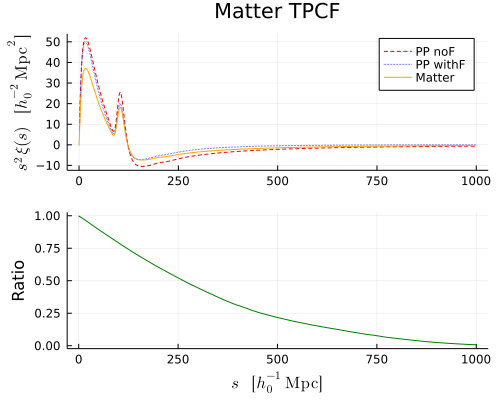

In [15]:
xs_1 = ss_ppm_noF
ys_1 = xis_ppm_noF .* xs_1 .^2

xs_2 = ss_ppm_withF
ys_2 = xis_ppm_withF .* xs_2 .^2
spline = Spline1D(xs_2, ys_2)

xs_3 = ss_matter
ys_3 = xis_matter .* xs_3 .^2

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter TPCF",
    label=["PP noF" "PP withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
plot!(p1, xs_3, ys_3, label = "Matter", ls=:solid, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    #ylim=(0.97,1.03), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

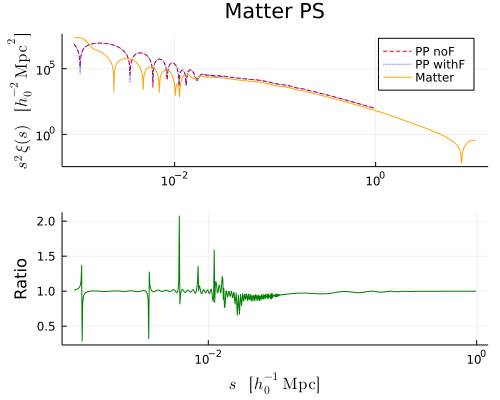

In [16]:
xs_1 = ks_ppm_noF
ys_1 = abs.(pks_ppm_noF)

xs_2 = ks_ppm_withF
ys_2 = abs.(pks_ppm_withF)
spline = Spline1D(xs_2, ys_2)

xs_3 = ks_matter
ys_3 = abs.(pks_matter)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Matter PS",
    label=["PP noF" "PP withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
plot!(p1, xs_3, ys_3, label = "Matter", ls=:solid, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(0.97,1.03), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## All GR effects TPCFs computation (with F)

In [17]:
#=
GaPSE.print_map_sum_ξ_LD_multipole(
    cosmo, DIR*"map_sum_xis_LD_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 50, N_χs_2 = 60);
=#

In [18]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*"map_sum_xis_GNC_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [19]:
#=
GaPSE.print_map_sum_ξ_GNCxLD_multipole(
    cosmo, DIR*"map_sum_xis_GNCxLD_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [20]:
#=
GaPSE.print_map_sum_ξ_LDxGNC_multipole(
    cosmo, DIR*"map_sum_xis_LDxGNC_L0_withF.txt", 
    10 .^ range(0, 3, length = 300);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [21]:
ss_LD, xis_sum_LD, all_xis_LD = readxyall(DIR*"map_sum_xis_LD_L0_withF.txt");
ss_GNC, xis_sum_GNC, all_xis_GNC = readxyall(DIR*"map_sum_xis_GNC_L0_withF.txt");
ss_GNCxLD, xis_sum_GNCxLD, all_xis_GNCxLD = readxyall(DIR*"map_sum_xis_GNCxLD_L0_withF.txt");
ss_LDxGNC, xis_sum_LDxGNC, all_xis_LDxGNC = readxyall(DIR*"map_sum_xis_LDxGNC_L0_withF.txt");

spline_LD_sum = Spline1D(ss_LD, xis_sum_LD; bc = "error");
spline_GNC_sum = Spline1D(ss_GNC, xis_sum_GNC; bc = "error");
spline_GNCxLD_sum = Spline1D(ss_GNCxLD, xis_sum_GNCxLD; bc = "error");
spline_LDxGNC_sum = Spline1D(ss_LDxGNC, xis_sum_LDxGNC; bc = "error");

In [22]:
ss_sum = ss_LD;
xis_sum = [spline_LD_sum(s) + spline_GNC_sum(s) + 
        spline_GNCxLD_sum(s) + spline_LDxGNC_sum(s)
        for s in ss_sum];

open(DIR*"xi_ALL_GR_TPCF_SUMMED.txt", "w") do io
    println(io, GaPSE.BRAND)
    println(io, "# This is the sum of all the GR effects TPCFs:")
    println(io, "# LD (16), GNC (25), GNCxLD (20), LDxGNC (20)\n#")
    GaPSE.parameters_used(io, cosmo; logo=false)
    println(io, "# s [Mpc/h_0] \t xi_ALLSUMMED")
    for (s,xi) in zip(ss_sum, xis_sum)
        println(io, "$s \t $xi")
    end
end

GaPSE.print_PS_multipole(DIR*"xi_ALL_GR_TPCF_SUMMED.txt", 
    DIR*"ps_ALL_GR_TPCF_SUMMED.txt"; 
    L = 0, N = 1000, pr = true, 
    int_s_min=1e-1, int_s_max=1e3);


I'm computing the PS_multipole from the file "Effective_fNL_z115_files/xi_ALL_GR_TPCF_SUMMED.txt" 

time needed for this Power Spectrum computation [in s] = 0.0006802082061767578



In [23]:
ks_sum, pks_sum = readxy(DIR*"ps_ALL_GR_TPCF_SUMMED.txt");

## Plots

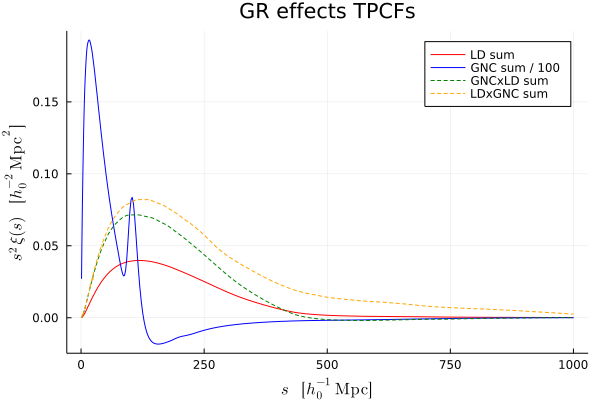

In [24]:
xs_1 = ss_LD
ys_1 = xis_sum_LD .* xs_1 .^2

xs_2 = ss_GNC
ys_2 = xis_sum_GNC .* xs_2 .^2 ./100

xs_3 = ss_GNCxLD
ys_3 = xis_sum_GNCxLD .* xs_3 .^2

xs_4 = ss_LDxGNC
ys_4 = xis_sum_LDxGNC .* xs_4 .^2

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(xs_1, ys_1,
    #xaxis=:log, yaxis=:log, 
    lc=:red, title = "GR effects TPCFs", #ylims =(-0.11, 0.31),
    label="LD sum", ls=:solid, legend=:topright,
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    xlabel = L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
plot!(p1, xs_2, ys_2, label = "GNC sum / 100", ls=:solid, lc =:blue)
plot!(p1, xs_3, ys_3, label = "GNCxLD sum", ls=:dash, lc =:green)
plot!(p1, xs_4, ys_4, label = "LDxGNC sum", ls=:dash, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

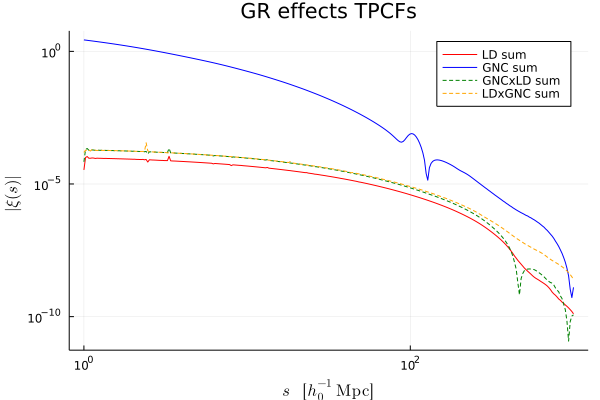

In [25]:
xs_1 = ss_LD
ys_1 = abs.(xis_sum_LD)

xs_2 = ss_GNC
ys_2 = abs.(xis_sum_GNC)

xs_3 = ss_GNCxLD
ys_3 = abs.(xis_sum_GNCxLD)

xs_4 = ss_LDxGNC
ys_4 = abs.(xis_sum_LDxGNC)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(xs_1, ys_1,
    xaxis=:log, yaxis=:log, 
    lc=:red, title = "GR effects TPCFs", #ylims =(-0.11, 0.31),
    label="LD sum", ls=:solid, legend=:topright,
    ylabel = L"|\xi(s)| ",
    xlabel = L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
plot!(p1, xs_2, ys_2, label = "GNC sum", ls=:solid, lc =:blue)
plot!(p1, xs_3, ys_3, label = "GNCxLD sum", ls=:dash, lc =:green)
plot!(p1, xs_4, ys_4, label = "LDxGNC sum", ls=:dash, lc =:orange)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

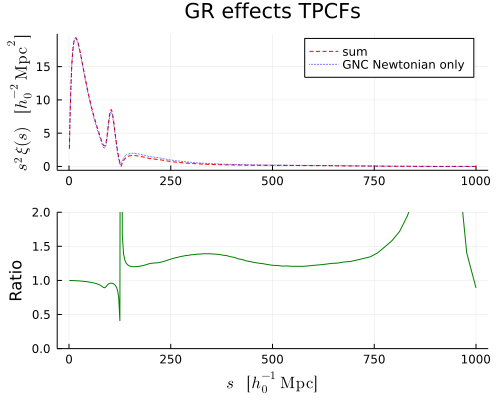

In [26]:
xs_1 = ss_sum
ys_1 = abs.(xis_sum .* xs_1 .^2)

xs_2 = ss_GNC
ys_2 = abs.(all_xis_GNC[1] .* xs_2 .^2)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "GR effects TPCFs",
    label=["sum" "GNC Newtonian only"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

## f_NL

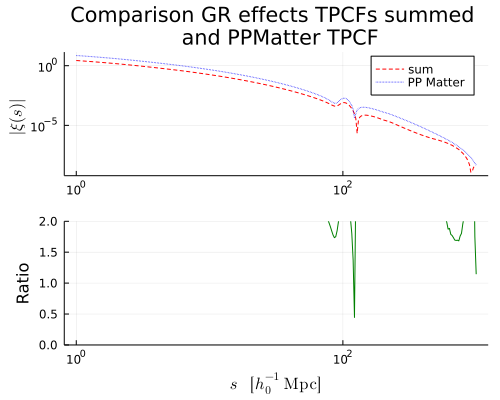

In [27]:
xs_1 = ss_sum
ys_1 = abs.(xis_sum)

xs_2 = ss_ppm_withF
ys_2 = abs.(xis_ppm_withF)
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects TPCFs summed \n and PPMatter TPCF",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|\xi(s)|",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

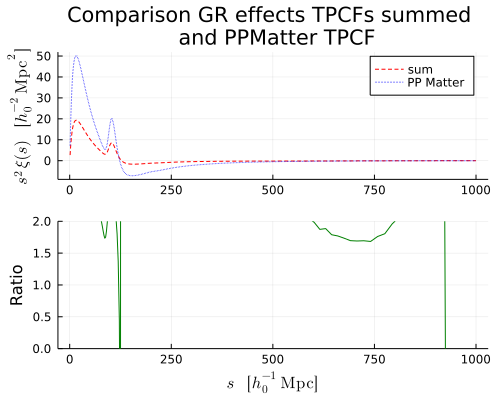

In [28]:
xs_1 = ss_sum
ys_1 = xis_sum .* xs_1 .^ 2

xs_2 = ss_ppm_withF
ys_2 = xis_ppm_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects TPCFs summed \n and PPMatter TPCF",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)

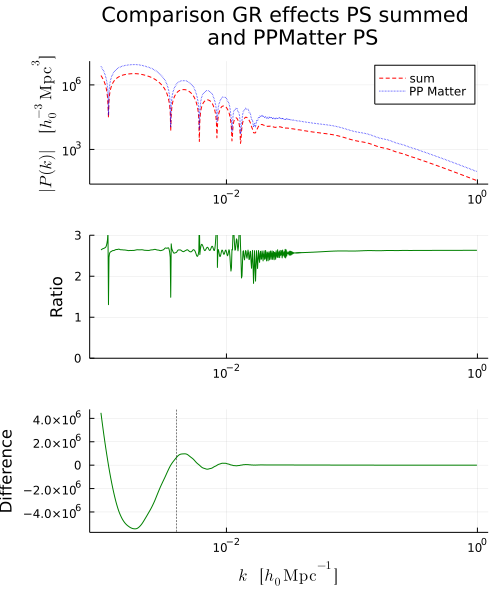

In [29]:
xs_1 = ks_sum
ys_1 = pks_sum

xs_2 = ks_ppm_withF
ys_2 = pks_ppm_withF
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects PS summed \n and PPMatter PS",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.0,3), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [VAXES], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
savefig(P, "PS_sum-matter.pdf")
display(P)

In [52]:
spline = Spline1D(ks_ppm_withF, pks_ppm_withF; bc = "error");
difference = [spline(k) - pk for (k,pk) in zip(ks_sum, pks_sum)];

In [31]:
f(x; a=1.0, b=1.0, c=1.0) = c + b*x + a*x^2;

In [32]:
LIM = 1.5e-3
c,b,a = GaPSE.polynomial_from_data(ks_sum, difference, [1.0, 1.0, 1.0], ks_sum[begin], LIM)

3 params, all sigmas_r ok


(3.173806680755772e13, -9.724699867166391e10, 6.98560349119233e7)

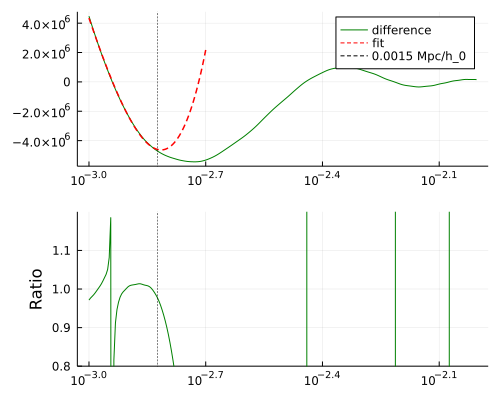

In [33]:
xs_1 = ks_sum[ks_sum .< 1e-2]
xs_2 = ks_sum[ks_sum .< 2e-3]
ys_1 = difference[ks_sum .< 1e-2]
ys_2 = [GaPSE.polynomial(x,c,b,a) for x in ks_sum[ks_sum .< 2e-3]]
spline = Spline1D(xs_2, ys_2; bc ="nearest")

p1 = plot(xs_1, ys_1, xaxis=:log, color=:green, label="difference")
ys = [f(k; a = 1e10, b = 1e8, c = 1.0) for k in ks_sum[ks_sum .< 5e-3]];
plot!(p1, xs_2, ys_2,
    color = :red, ls=:dash, lw=1.5, label="fit")
vline!(p1, [LIM], label="$LIM Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [LIM], label="$LIM Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

plot(p1, p2,  size=(500, 400), layout= @layout [ x ; y ] )

In [34]:
function chi_square(ys_expected, ys_observed)
    sum([(o-e)^2/e for (o,e) in zip(ys_observed,ys_expected)])
end

chi_square (generic function with 1 method)

In [35]:
chi_square(difference[ks_sum .< LIM], [GaPSE.polynomial(x,c,b,a) for x in ks_sum[ks_sum .< LIM]])

-270111.45852284966

In [45]:
?LogUniform

search: LogUniform



```
LogUniform(a,b)
```

A positive random variable `X` is log-uniformly with parameters `a` and `b` if the logarithm of `X` is `Uniform(log(a), log(b))`. The *log uniform* distribution is also known as *reciprocal distribution*.

```julia
LogUniform(1,10)
```

External links

  * [Log uniform distribution on Wikipedia](https://en.wikipedia.org/wiki/Reciprocal_distribution)


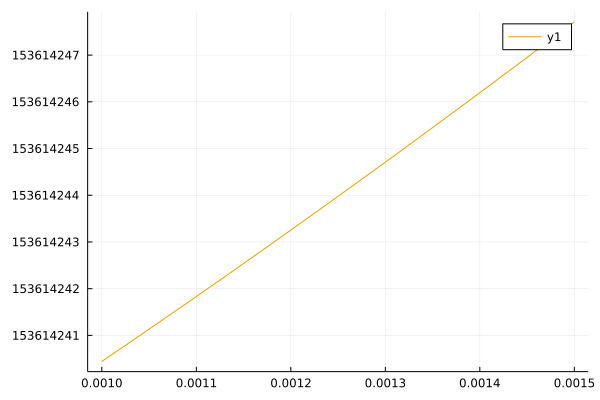

In [51]:
plot(xs, ys)

In [111]:
pyplot()

# Define a simple Normal model with unknown mean and variance.
@model function demo_polyn(x, y)
    a ~ Uniform(-1e3, 1e3)
    b ~ Uniform(-1e3, 1e3)
    c ~ Uniform(-1e3, 1e3)
    s² ~ Uniform(0, 10)
    m ~ Uniform(-10, 10)
    d = y .- (a .+ b .* x .+ c.*x.^2)
    d ~  Normal(m, s²)
end

#  Run sampler, collect results
xs = ks_sum[ks_sum.<LIM]
ys = difference[ks_sum .< LIM] ./ 1e6
chn = sample(demo_polyn(xs, ys), HMC(0.1, 5), 1000)

# Summarise results
summaries, quantiles = describe(chn);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


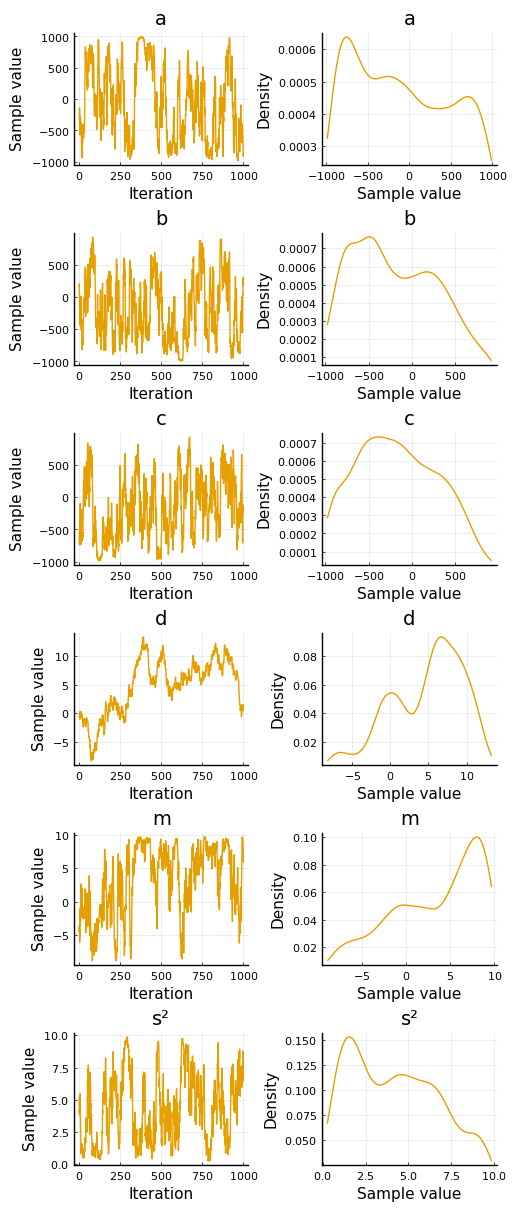

In [112]:
# Plot and save results
p = plot(chn, size=(500, 1200))
savefig("gdemo-plot.png")
#display(p)

## useless things

In [9]:
xis = [6.56153063354608e-7, 6.560277709955939e-7, 6.558874183374276e-7, 6.557158113483776e-7, 6.55501153206144e-7, 6.552556698969025e-7, 6.54958669097401e-7, 6.545901417671655e-7, 6.541792744071797e-7, 6.5368260220231e-7, 6.530845890374138e-7, 6.523589917863664e-7, 6.514672665591093e-7, 6.506381077322805e-7, 6.493545751967148e-7, 6.498875909759789e-7, 6.646274549783365e-7, -0.00883693271069223, 6.298415569638383e-7, 6.4082780185342e-7, 6.384896590127004e-7, 6.356775965865449e-7, 6.325770043373896e-7, 6.291185839302062e-7, 6.253118583633126e-7, 6.20392138377278e-7, 6.152192262326985e-7, 6.097457615341244e-7, 6.034457248950251e-7, 5.964930544602926e-7, 5.887495995514081e-7, 5.801551379352546e-7, 5.706465071352672e-7, 5.602229464387584e-7, 5.489747605089532e-7, 5.368536870890438e-7, 5.23872635077563e-7, 5.10452115973695e-7, 4.967830679668002e-7, 4.827298928231318e-7, 4.6845018896850587e-7, 4.53934284408009e-7, 4.391748800481582e-7, 4.24216015397236e-7, 4.090230946093395e-7, 3.935831645213197e-7, 3.780530022134148e-7, 3.624631767419584e-7, 3.4676427184099376e-7, 3.310234871682242e-7, 3.152765562369451e-7, 2.99599224251273e-7, 2.8401123452119726e-7, 2.684549607376347e-7, 2.530629760273618e-7, 2.3804646597679933e-7, 2.232583001676521e-7, 2.087569466840035e-7, 1.946340866876571e-7, 1.809283184050362e-7, 1.6763123698840323e-7, 1.54863502265058e-7, 1.4258837854881586e-7, 1.3085488564993624e-7, 1.1967797594970095e-7, 1.0909676836200571e-7, 9.910717532106183e-8, 8.973136215517943e-8, 8.10075327696677e-8, 7.286191449949798e-8, 6.53285792353512e-8, 5.836201614529361e-8, 5.1986267689603876e-8, 4.619268988386962e-8, 4.086378166307915e-8, 3.6034850089745295e-8, 3.180269186706247e-8, 2.801101554170173e-8, 2.465428982090318e-8, 2.1682991193497672e-8, 1.903531004833906e-8, 1.6700374894014186e-8, 1.4649118489362893e-8, 1.2856400894911506e-8, 1.1305236356569956e-8, 9.963702984848503e-9, 8.809353753036147e-9, 7.81654399368091e-9, 6.9627292439915004e-9, 6.223221887599955e-9, 5.580514243132858e-9, 5.0230209463117735e-9, 4.5271483675958165e-9, 4.087673195816193e-9, 3.6995314954064047e-9, 3.3481426480105438e-9, 3.036028922819589e-9, 2.754874628930334e-9, 2.505416692563507e-9, 2.2789925402062165e-9];
calc_xis = [6.561505539497935e-7, 6.560240233518769e-7, 6.558829635645758e-7, 6.55711247844233e-7, 6.554960252490053e-7, 6.552513819506409e-7, 6.549540939783271e-7, 6.545845456620884e-7, 6.541759647566269e-7, 6.536778171077202e-7, 6.530862652696665e-7, 6.523555022612716e-7, 6.514635278542542e-7, 6.506406465196563e-7, 6.492407920721238e-7, 6.49887200094522e-7, 6.5534639937839e-7, -0.013255721923088814, 6.298354655501604e-7, 6.408280306553711e-7, 6.384833409604601e-7, 6.356785519550699e-7, 6.325775346358096e-7, 6.291181593781197e-7, 6.252960175308653e-7, 6.203720897813102e-7, 6.152773762485524e-7, 6.097457214011635e-7, 6.034513590063908e-7, 5.96493008564549e-7, 5.887495609745443e-7, 5.801541577072242e-7, 5.706466172413278e-7, 5.602234555425186e-7, 5.489747241018026e-7, 5.368538193987804e-7, 5.238726577642715e-7, 5.104468019940111e-7, 4.967830368699972e-7, 4.827300241192071e-7, 4.68450183103825e-7, 4.5393428209110836e-7, 4.391748813053438e-7, 4.242160114315082e-7, 4.0902308778397073e-7, 3.9358314359173417e-7, 3.7805300153049515e-7, 3.624631765078813e-7, 3.4676427093059507e-7, 3.310235013366264e-7, 3.152765559225727e-7, 2.995992208380607e-7, 2.8401123605428327e-7, 2.684549609103523e-7, 2.530629760503615e-7, 2.3804646438033458e-7, 2.2325830057881496e-7, 2.087569463578362e-7, 1.9463408664843531e-7, 1.809283184017196e-7, 1.676312366354167e-7, 1.5486350223026908e-7, 1.4258837854839917e-7, 1.308548856261112e-7, 1.1967797614616166e-7, 1.0909676834125743e-7, 9.910717531901778e-8, 8.973136214934823e-8, 8.100753278856186e-8, 7.286191449823571e-8, 6.532857923603334e-8, 5.836201615917643e-8, 5.198626768941576e-8, 4.6192689883910167e-8, 4.0863781661912514e-8, 3.603485005559881e-8, 3.18026918668426e-8, 2.8011015532566175e-8, 2.4654289820768808e-8, 2.1682991173152805e-8, 1.903531004565542e-8, 1.6700374893644516e-8, 1.4649118488781418e-8, 1.2856400893678686e-8, 1.1305236356378212e-8, 9.963702979798655e-9, 8.809353752916779e-9, 7.816543993677596e-9, 6.962729240882803e-9, 6.223221887509389e-9, 5.580514242927377e-9, 5.023020946328979e-9, 4.527148367583253e-9, 4.087673195846005e-9, 3.699531495309815e-9, 3.3481426476914977e-9, 3.0360289172745843e-9, 2.754874631094892e-9, 2.505416692608282e-9, 2.278992540120985e-9];

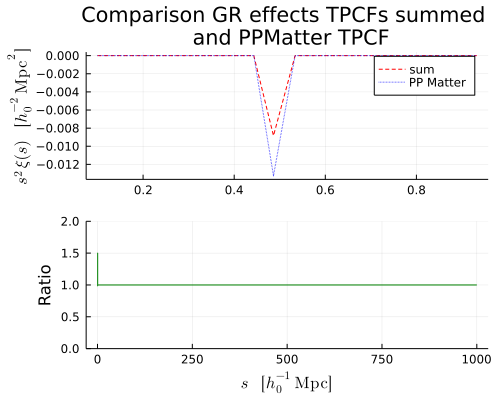

In [14]:
xs_1 =  10 .^ range(-1, 3, length=100)
ys_1 = xis

xs_2 = 10 .^ range(-1, 3, length=100)
ys_2 = calc_xis
spline = Spline1D(xs_2, ys_2)

S_VLIM = 8
S_VLIM_F = @sprintf("%.2f", S_VLIM)

LIM = 1

p1 = plot([xs_1[xs_1 .< LIM], xs_2[xs_2 .< LIM]], [ys_1[xs_1 .< LIM], ys_2[xs_2 .< LIM]],
    #xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    title = "Comparison GR effects TPCFs summed \n and PPMatter TPCF",
    label=["sum" "PP Matter"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi(s) \quad [h_0^{-2} \,\mathrm{Mpc}^{2}]",
    legend=:topright)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    #xaxis=:log,
    ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; z ] )
#savefig(P, "PS_AutoDoppler_L0.pdf")
#display(P)